<a href="https://colab.research.google.com/github/AnuThmsn/DNN_Estimation_of_CBF_and_ATT_ASL/blob/main/DNN_Estimation_of_CBF_and_ATT_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [11]:

import torch

# Define the device for local GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [12]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm


In [13]:
def asl_signal_paper(CBF, ATT, PLDs, LDs):
    """
    Implementation of Equation 1 from Ishida et al.
    CBF: (N,) in mL/100g/min
    ATT: (N,) in ms
    """
    # Constants
    alpha, beta = 0.85, 0.75
    lamb, T1t, T1a = 0.9, 1.2, 1.66
    M0 = 1.0 # Baseline

    # Unit Conversions
    f = CBF / 6000.0        # mL/100g/min -> sec^-1
    delta = ATT / 1000.0    # ms -> sec
    w = PLDs / 1000.0       # ms -> sec
    tau = LDs / 1000.0      # ms -> sec

    # Scaling as per paper: DeltaM / M0 * 100,000
    # 1.0% signal corresponds to 1000 units
    scaling_factor = 100000

    # Equation 1: ΔM = 2 * alpha * beta * T1t * f * (M0/lambda) * exp(-delta/T1a) * ...
    term_common = 2 * alpha * beta * T1t * (f / lamb) * np.exp(-delta / T1a)

    # We need to broadcast across the 5 boluses
    # term3 & 4 handle the arrival and duration
    # exp(-max(w-delta, 0)/T1t) - exp(-max(tau+w-delta, 0)/T1t)

    signals = []
    for i in range(len(PLDs)):
        e1 = np.exp(-np.maximum(w[i] - delta, 0) / T1t)
        e2 = np.exp(-np.maximum(tau[i] + w[i] - delta, 0) / T1t)
        signals.append(term_common * (e1 - e2))

    return np.stack(signals, axis=1) * scaling_factor

In [14]:
# Multi-delay ASL acquisition parameters (from the paper)
PLDs = np.array([700, 2033, 3366, 700, 3000])   # ms
LDs  = np.array([1333, 1333, 1333, 4000, 4000]) # ms

NUM_BOLUSES = len(PLDs)


In [15]:
# Ground truth ranges
CBF_MIN, CBF_MAX = 20, 90        # mL/100g/min
ATT_MIN, ATT_MAX = 500, 3000     # ms


In [16]:
N_TRAIN = 5_000_000  # Paper uses 5 million
N_VAL   = 100_000    # Paper uses 100 thousand
N_TEST  = 1_000_000  # Paper uses 1 million

In [17]:
def add_rician_noise(clean_delta_m, rSNR):
    """
    Follows Figure 1 (b-d). Adds noise to Control and Label, then subtracts.
    """
    # Paper reference: rSNR is based on a specific condition
    # CBF=50, ATT=1600, PLD=2000, LD=1800.
    # At this condition, DeltaM/M0 = 1.0% = 1000 units.
    # Therefore, sigma = 1000 / rSNR
    sigma = 1000.0 / rSNR

    # Assume M0 (Control) is scaled to 100,000 units
    # Control (C) = 100,000; Label (L) = 100,000 - DeltaM
    C_real = 100000.0
    L_real = C_real - clean_delta_m

    # Add Gaussian noise to Real and Imaginary channels
    # Noise is added to both Control and Label separately
    # Control
    RC = C_real + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    IC = 0.0 + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    # Label
    RL = L_real + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    IL = 0.0 + np.random.normal(0, sigma[:, None], clean_delta_m.shape)

    # Magnitude Calculation (Rician)
    mag_C = np.sqrt(RC**2 + IC**2)
    mag_L = np.sqrt(RL**2 + IL**2)

    # Final observed DeltaM
    return mag_C - mag_L

In [18]:
import numpy as np
from tqdm import tqdm

# 1. Define the ground truth sampler first
def sample_ground_truth(n_samples):
    CBF = np.random.uniform(CBF_MIN, CBF_MAX, n_samples)
    ATT = np.random.uniform(ATT_MIN, ATT_MAX, n_samples)
    return CBF, ATT

# 2. Define the large dataset generator
def generate_dataset(n_pairs, rsnr_levels):
    CBF, ATT = sample_ground_truth(n_pairs)
    X, Y = [], []

    for rsnr in rsnr_levels:
        clean = asl_signal_paper(CBF, ATT, PLDs, LDs)
        noisy = add_rician_noise(clean, np.full(len(clean), rsnr))
        X.append(noisy)
        Y.append(np.stack([CBF, ATT], axis=1))

    return np.vstack(X), np.vstack(Y)

# Training
rsnr_train = np.linspace(2, 20, 500)
X_train, y_train = generate_dataset(10_000, rsnr_train)

# Validation
X_val, y_val = generate_dataset(200, rsnr_train)

# Test
rsnr_test = np.linspace(2, 20, 100)
X_test, y_test = generate_dataset(10_000, rsnr_test)



In [19]:
def asl_signal(CBF, ATT, PLD, LD,
               alpha=0.85, beta=0.75,
               M0=1.0, lamb=0.9,
               T1t=1.2, T1a=1.66):
    """
    Vectorized single-compartment ASL signal model
    Returns ΔM / M0
    """
    f = CBF / 6000          # mL/100g/min → per second
    delta = ATT / 1000     # ms → sec
    w = PLD / 1000
    tau = LD / 1000

    term1 = 2 * alpha * beta * M0 / lamb
    term2 = f * np.exp(-delta / T1a)

    post_delay = np.maximum(w - delta, 0)
    bolus_duration = np.minimum(tau, post_delay)

    term3 = np.exp(-post_delay / T1t)
    term4 = 1 - np.exp(-bolus_duration / T1t)

    return term1 * term2 * term3 * term4


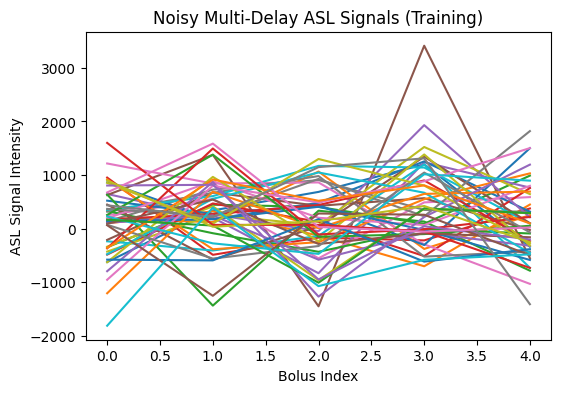

In [20]:
plt.figure(figsize=(6,4))
plt.plot(X_train[:50].T)
plt.xlabel("Bolus Index")
plt.ylabel("ASL Signal Intensity")
plt.title("Noisy Multi-Delay ASL Signals (Training)")
plt.show()


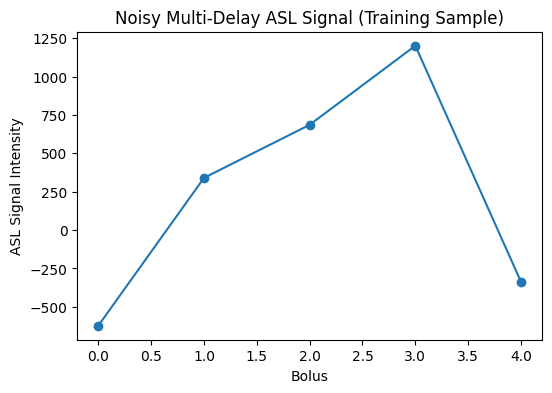

In [21]:
idx = 0  # sample index

plt.figure(figsize=(6,4))
plt.plot(X_train[idx], marker='o')
plt.xlabel("Bolus")
plt.ylabel("ASL Signal Intensity")
plt.title("Noisy Multi-Delay ASL Signal (Training Sample)")
plt.show()


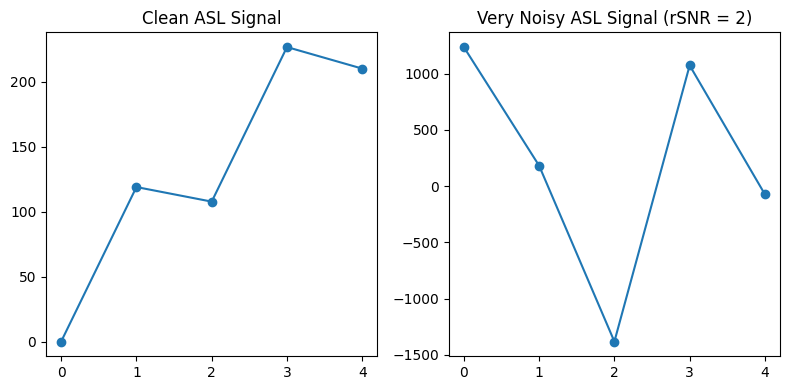

In [22]:
# Generate ONE clean signal for visualization only
CBF_vis, ATT_vis = sample_ground_truth(1)
X_clean_vis = asl_signal_paper(CBF_vis, ATT_vis, PLDs, LDs)

# Force very low rSNR = 2
low_rsnr = np.array([2.0])
X_very_noisy = add_rician_noise(X_clean_vis, low_rsnr)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(X_clean_vis[0], marker='o')
plt.title("Clean ASL Signal")

plt.subplot(1,2,2)
plt.plot(X_very_noisy[0], marker='o')
plt.title("Very Noisy ASL Signal (rSNR = 2)")

plt.tight_layout()
plt.show()


In [23]:
y_train_CBF = torch.tensor(y_train[:, 0:1], dtype=torch.float32).to(device)
y_train_ATT = torch.tensor(y_train[:, 1:2], dtype=torch.float32).to(device)

y_val_CBF = torch.tensor(y_val[:, 0:1], dtype=torch.float32).to(device)
y_val_ATT = torch.tensor(y_val[:, 1:2], dtype=torch.float32).to(device)


In [24]:
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_t   = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(device)


In [25]:
# -------------------------------
# Target normalization utilities
# -------------------------------

CBF_MIN, CBF_MAX = 20.0, 90.0
ATT_MIN, ATT_MAX = 500.0, 3000.0




In [26]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight) # He Initialization
        m.bias.data.fill_(0.01)

class IshidaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 1)
        )

    def forward(self, x):
        return self.net(x)


In [27]:
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, optimizer, X, y, X_val, y_val, epochs=200, batch_size=2048):
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_losses, val_losses = [], []
    best_loss = float('inf')
    patience = 10
    trigger_times = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            preds = model(batch_X)
            loss = nn.MSELoss()(preds, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            v_loss = nn.MSELoss()(model(X_val), y_val).item()

        train_losses.append(epoch_loss / len(loader))
        val_losses.append(v_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {v_loss:.6f}")

        # Early Stopping & Saving Best Model
        if v_loss < best_loss:
            best_loss = v_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                model.load_state_dict(torch.load('best_model.pth'))
                break

    return train_losses, val_losses

In [28]:
# Reset Models
CBF_net = IshidaNet().to(device)
ATT_net = IshidaNet().to(device)


optimizer_CBF = optim.Adam(CBF_net.parameters(), lr=1e-3)
optimizer_ATT = optim.Adam(ATT_net.parameters(), lr=1e-3)

# Train



In [29]:
train_losses_CBF, val_losses_CBF = train_model(
    CBF_net,
    optimizer_CBF,
    X_train_t,
    y_train_CBF,
    X_val_t,
    y_val_CBF
)


Epoch 1/200 | Train Loss: 194.421647 | Val Loss: 183.422562
Epoch 2/200 | Train Loss: 186.416843 | Val Loss: 182.453735
Epoch 3/200 | Train Loss: 186.082987 | Val Loss: 183.034454
Epoch 4/200 | Train Loss: 185.904706 | Val Loss: 184.297516
Epoch 5/200 | Train Loss: 185.768146 | Val Loss: 187.296188
Epoch 6/200 | Train Loss: 185.668067 | Val Loss: 182.561081
Epoch 7/200 | Train Loss: 185.616989 | Val Loss: 182.485291
Epoch 8/200 | Train Loss: 185.577214 | Val Loss: 182.676697
Epoch 9/200 | Train Loss: 185.528450 | Val Loss: 183.184357
Epoch 10/200 | Train Loss: 185.467588 | Val Loss: 183.938599
Epoch 11/200 | Train Loss: 185.426072 | Val Loss: 182.735062
Epoch 12/200 | Train Loss: 185.393548 | Val Loss: 184.894989
Early stopping triggered at epoch 12!


In [30]:
train_losses_ATT, val_losses_ATT = train_model(
    ATT_net,
    optimizer_ATT,
    X_train_t,
    y_train_ATT,
    X_val_t,
    y_val_ATT
)


Epoch 1/200 | Train Loss: 237533.319993 | Val Loss: 164493.218750
Epoch 2/200 | Train Loss: 176196.483614 | Val Loss: 167566.812500
Epoch 3/200 | Train Loss: 175957.261664 | Val Loss: 164707.812500
Epoch 4/200 | Train Loss: 175788.577351 | Val Loss: 164060.015625
Epoch 5/200 | Train Loss: 175700.536644 | Val Loss: 165429.421875
Epoch 6/200 | Train Loss: 175664.037476 | Val Loss: 163842.593750
Epoch 7/200 | Train Loss: 175600.210829 | Val Loss: 164382.812500
Epoch 8/200 | Train Loss: 175551.959786 | Val Loss: 164580.750000
Epoch 9/200 | Train Loss: 175518.965544 | Val Loss: 163851.000000
Epoch 10/200 | Train Loss: 175491.108044 | Val Loss: 165133.640625
Epoch 11/200 | Train Loss: 175439.496782 | Val Loss: 165344.984375
Epoch 12/200 | Train Loss: 175443.236288 | Val Loss: 163838.875000
Epoch 13/200 | Train Loss: 175358.993557 | Val Loss: 163726.625000
Epoch 14/200 | Train Loss: 175357.032472 | Val Loss: 164092.890625
Epoch 15/200 | Train Loss: 175355.311208 | Val Loss: 164442.156250
Epoc

In [31]:
CBF_net.eval()
ATT_net.eval()

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    CBF_pred = CBF_net(X_test_t).cpu().numpy().flatten()
    ATT_pred = ATT_net(X_test_t).cpu().numpy().flatten()




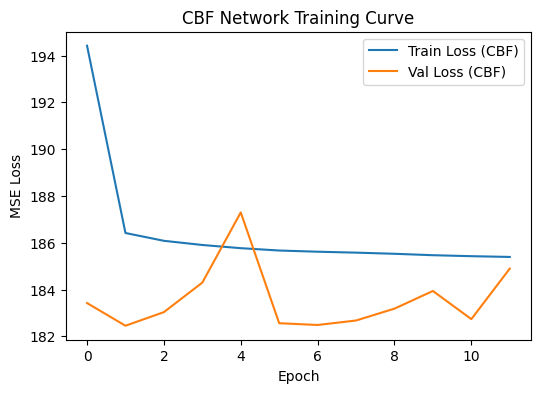

In [32]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_CBF, label="Train Loss (CBF)")
plt.plot(val_losses_CBF, label="Val Loss (CBF)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CBF Network Training Curve")
plt.legend()
plt.show()


In [33]:
def NMAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) / np.mean(y_true)

def NRMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2)) / np.mean(y_true)


In [34]:
CBF_gt = y_test[:, 0]
ATT_gt = y_test[:, 1]



In [35]:
cbf_nmae = NMAE(CBF_gt, CBF_pred)
cbf_nrmse = NRMSE(CBF_gt, CBF_pred)

att_nmae = NMAE(ATT_gt, ATT_pred)
att_nrmse = NRMSE(ATT_gt, ATT_pred)

print("CBF  NMAE :", cbf_nmae)
print("CBF  NRMSE:", cbf_nrmse)
print("ATT  NMAE :", att_nmae)
print("ATT  NRMSE:", att_nrmse)


CBF  NMAE : 0.19213538766009539
CBF  NRMSE: 0.24721381636512438
ATT  NMAE : 0.1762806988713836
ATT  NRMSE: 0.2393019510752407


In [36]:
def weighted_delay(asl_signal, PLDs):
    """
    asl_signal: (N, num_boluses)
    PLDs: array of delays (ms)
    """
    numerator = np.sum(asl_signal * PLDs, axis=1)
    denominator = np.sum(asl_signal, axis=1) + 1e-8
    return numerator / denominator


In [38]:
ATT_grid = np.linspace(ATT_MIN, ATT_MAX, 200)
CBF_grid = np.linspace(CBF_MIN, CBF_MAX, 10)

wd_table = []

for att in ATT_grid:
    wd_vals = []

    for cbf in CBF_grid:
        sig = asl_signal_paper(
            np.array([cbf]),
            np.array([att]),
            PLDs,
            LDs
        )

        # NO NOISE — paper-correct
        wd = weighted_delay(sig, PLDs)
        wd_vals.append(wd[0])

    wd_table.append(np.mean(wd_vals))

wd_table = np.array(wd_table)


In [39]:
def wd_to_att(wd_values, wd_table, ATT_grid):
    idx = np.abs(wd_table[None, :] - wd_values[:, None]).argmin(axis=1)
    return ATT_grid[idx]


In [40]:
def estimate_cbf_ls(asl_signal, ATT_est):
    delta = ATT_est / 1000
    A = []

    for i in range(NUM_BOLUSES):
        w = PLDs[i] / 1000
        tau = LDs[i] / 1000

        coeff = np.exp(-delta / 1.66) * (
            np.exp(-np.maximum(w - delta, 0) / 1.2) -
            np.exp(-np.maximum(tau + w - delta, 0) / 1.2)
        )
        A.append(coeff)

    A = np.stack(A, axis=1)
    B = asl_signal

    return np.sum(A * B, axis=1) / (np.sum(A * A, axis=1) + 1e-8)


In [42]:
# 1. Compute weighted delay on test data
WD_test = weighted_delay(X_test, PLDs)

# 2. Convert WD → ATT using lookup table
ATT_WD = wd_to_att(WD_test, wd_table, ATT_grid)

# 3. Reconstruct rSNR for test set
rSNR_test = np.repeat(rsnr_test, 10_000)

# 4. Low-SNR mask
low_snr_mask = rSNR_test < 6

# 5. Ground truth ATT (low SNR)
ATT_gt_low = ATT_gt[low_snr_mask]

# 6. WD-based ATT (low SNR)
ATT_WD_low = ATT_WD[low_snr_mask]

# 7. Compare WD vs DNN
print("WD ATT NRMSE (low rSNR):",
      NRMSE(ATT_gt_low, ATT_WD_low))

print("DNN ATT NRMSE (low rSNR):",
      NRMSE(ATT_gt_low, ATT_pred[low_snr_mask]))


WD ATT NRMSE (low rSNR): 0.5782501245692033
DNN ATT NRMSE (low rSNR): 0.33531453049970417


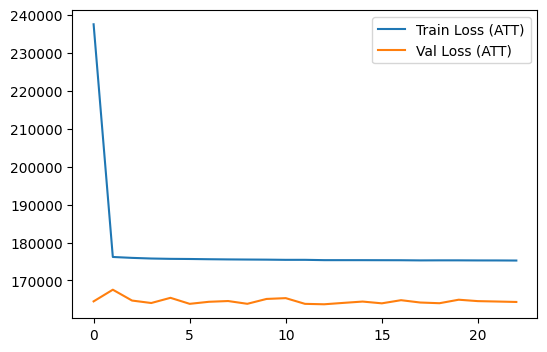

In [43]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_ATT, label="Train Loss (ATT)")
plt.plot(val_losses_ATT, label="Val Loss (ATT)")
plt.legend()
plt.show()


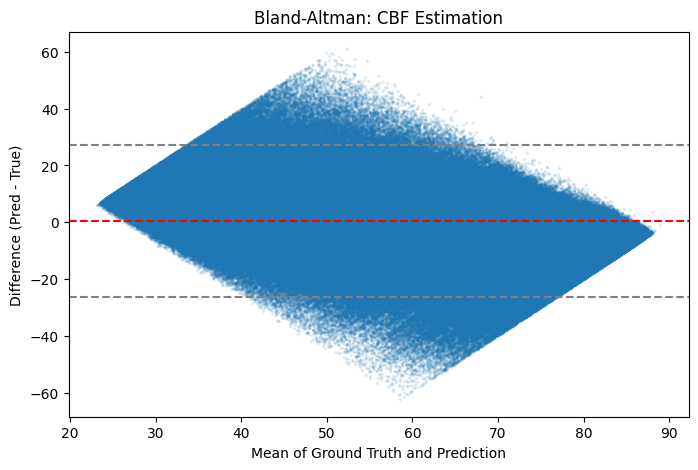

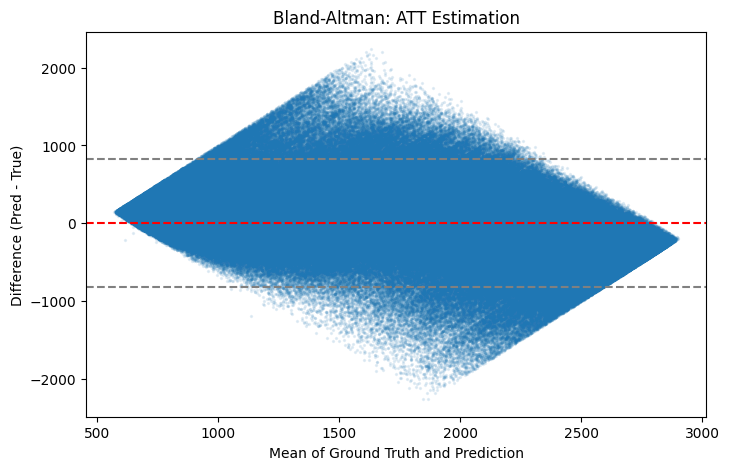

In [44]:
def plot_bland_altman(true, pred, title):
    mean = (true + pred) / 2
    diff = pred - true
    md = np.mean(diff)
    sd = np.std(diff)

    plt.figure(figsize=(8, 5))
    plt.scatter(mean, diff, alpha=0.1, s=2)
    plt.axhline(md, color='red', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title(f"Bland-Altman: {title}")
    plt.xlabel("Mean of Ground Truth and Prediction")
    plt.ylabel("Difference (Pred - True)")
    plt.show()

# Run after re-training
plot_bland_altman(CBF_gt, CBF_pred.flatten(), "CBF Estimation")
plot_bland_altman(ATT_gt, ATT_pred.flatten(), "ATT Estimation")